# Flux Qubit (3JJ + L)

##  Introduction 

Calculating the flux-tuning eigenvalues for a three-junction flux qubit incorporating nonzero linear loop inductance. The goal is to compare SQcircuit's solution to a case-specific solution following the two papers mentioned below.

Reference for circuit model and parameters: https://journals.aps.org/prb/abstract/10.1103/PhysRevB.73.174526

<img src="pics/fluxQubit_pic1.png" width="230" align="left" />

Note:

2D Brillouin zone for periodic coordinates used an incorrect unit cell of 2x the correct size, leading to parasitic doublets in the low spectrum (with both curves of a doublet close to the correct single curve), and large deviations in the high spectrum. This error was mentioned and corrected by Yamamoto et. al. NJP 2014: https://iopscience.iop.org/article/10.1088/1367-2630/16/1/015017/pdf

In [1]:
# Setup
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt

First we calculate the value of the circuit components from paper:

In [2]:
# Fundamental constants
h    = 6.626e-34
GHz = 1e9
e0   = 1.602e-19
phi0 = h/(2*e0)
phi0_red = phi0/2/np.pi

# Circuit parameters in paper's convention
EJ = 50.0 * GHz * h
EC = 1.0 * GHz * h
αQ = 0.63
βQ = 0.15
κQ = 0.00
σQ = 0.00

In [3]:
# Pre-convert to explicit circuit elements for checking values
L_val   = βQ*(phi0_red**2/EJ)*(1/(1+κQ) + 1/(1-κQ) + 1/αQ)
C1_val  = (e0**2/(2*EC))*(1+κQ)
C2_val  = (e0**2/(2*EC))*(1-κQ)
C3_val  = (e0**2/(2*EC))*(αQ)
JJ1_val = EJ/h*(1+κQ)
JJ2_val = EJ/h*(1-κQ)
JJ3_val = EJ/h*(αQ)

## Circuit Description

In [4]:
# Initialize loop(s)
loop1 = sq.Loop(0.0) # "Value" corresponds to phiExt / phi0 threading the loop (can change later)

In [5]:
# Create circuit
L  = sq.Inductor(L_val, 'H', loops=[loop1]) 
C1 = sq.Capacitor(C1_val, 'F')
C2 = sq.Capacitor(C2_val, 'F')
C3 = sq.Capacitor(C3_val, 'F')
JJ1 = sq.Junction(JJ1_val, 'Hz', loops=[loop1]) 
JJ2 = sq.Junction(JJ2_val, 'Hz', loops=[loop1])
JJ3 = sq.Junction(JJ3_val, 'Hz', loops=[loop1])

elements = {
    (0, 1): [JJ1, C1], # Only include C_j if not included in JJ_j object
    (1, 2): [JJ2, C2],
    (2, 3): [JJ3, C3],
    (0, 3): [L]
}

cr1 = sq.Circuit(elements)

In [6]:
# Ask about the ordering and Hilbert spaces for the coordinates (modes)
cr1.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Circuit Spectrum

To determine the size of the Hilbert space, we specify the truncation number for each circuit mode via `set_trunc_nums()` method. Note that this is a necessary step before diagonalizing the circuit.

In [7]:
# Set truncation numbers, desired eigenvalues, and flux sweep
n1 = 1 # harmonic [see cr.description()]
n2 = 6 # charge [see cr.description()]
n3 = 6 # charge [see cr.description()]

cr1.set_trunc_nums([n1, n2, n3])

n_eig = 7
n_ext = 300
phi_ext = np.linspace(0.0, 1.0, n_ext)

To generate the spectrum of the circuit, firstly, we need to change and sweep the external flux of `loop1` by the `set_flux()` method. Then, we need to find the eigenfrequencies of the circuit that correspond to that external flux via `diag()` method. The following lines of code find the `spec` a 2D NumPy array so that each column of it contains the eigenfrequencies with respect to its external flux. 

In [8]:
# Calculate eigenvalue spectrum
spec = np.zeros((n_eig, len(phi_ext)))

for i, phi in enumerate(phi_ext):
    loop1.set_flux(phi)
    spec[:, i], _ = cr1.diag(n_eig=n_eig)

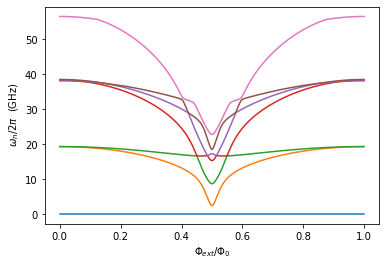

In [9]:
# Display eigenvalue spectrum
plt.figure()
for i in range(n_eig):
    plt.plot(phi_ext, (spec[i, :] - spec[0, :]))

plt.xlabel(r"$\Phi_{ext}/\Phi_0$")
plt.ylabel(r" $\omega_n / 2\pi$  (GHz)")
plt.show()